In [15]:
%matplotlib inline
import os
import glob
import json
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import sqlite3
import lsst.afw.geom as afw_geom
import lsst.afw.cameraGeom as cameraGeom
import lsst.daf.persistence as dp
# The lsst_sims code issues some ignorable warnings regarding ids used for querying the object
# databases.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import lsst.sims.coordUtils
    from lsst.sims.catUtils.utils import ObservationMetaDataGenerator
    from lsst.sims.utils import getRotSkyPos

In [6]:
import warnings
import sqlite3
import numpy as np
from lsst.afw import cameraGeom
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    from lsst.sims.coordUtils import getCornerRaDec
    from lsst.sims.catUtils.utils import ObservationMetaDataGenerator
    from lsst.sims.utils import getRotSkyPos
import desc.imsim

class Run20Region:
    def __init__(self, ra_mid=61.855, ne_corner=(71.46, -27.25),
                 dec_range=(-44.33, -27.25)):
        self._ra_mid = ra_mid
        ra0 = ne_corner[0]
        cos_dec0 = np.cos(np.radians(ne_corner[1]))
        self._dra_scale = np.abs(ra0 - self._ra_mid)*cos_dec0
        self._dec_range = dec_range

    def contains(self, ra, dec):
        if dec < min(self._dec_range) or dec > max(self._dec_range):
            return False
        dra = np.abs(self._dra_scale/np.cos(np.radians(dec)))
        if np.abs(ra - self._ra_mid) > dra:
            return False
        return True

    def trim_sensors(self, visit, opsim_db='/global/projecta/projectdirs/lsst/groups/SSim/DC2/minion_1016_desc_dithered_v4.db'):
        obs_gen = ObservationMetaDataGenerator(database=opsim_db,
                                               driver='sqlite')
        with sqlite3.connect(opsim_db) as conn:
            curs = conn.execute('''select descDitheredRA, descDitheredDec,
                                   descDitheredRotTelPos from summary
                                   where obshistid={}'''.format(visit))
            ra, dec, rottelpos = [np.degrees(x) for x in curs][0]

        # An ObservationMetaData object used to pass the pointing info to
        # the function in lsst.sims.coordUtils that provides the CCD
        # coordinates.
        obs_md = obs_gen.getObservationMetaData(obsHistID=visit,
                                                boundType='circle',
                                                boundLength=0.1)[0]
        obs_md.pointingRA = ra
        obs_md.pointingDec = dec
        obs_md.OpsimMetaData['rotTelPos'] = rottelpos

        # Convert the rotation angle of the sky relative to the
        # telescope to the sky angle relative to the camera.
        obs_md.rotSkyPos = getRotSkyPos(ra, dec, obs_md, rottelpos)

        camera = desc.imsim.get_obs_lsstSim_camera()

        sensors = []
        for det in list(camera):
            det_name = det.getName()
            if det.getType() != cameraGeom.SCIENCE:
                continue
            corners = np.array(getCornerRaDec(det_name, camera, obs_md))
            if any([run20_region.contains(*corner) for corner in corners]):
                sensors.append(det_name)
        return sensors


In [7]:
def make_patch(vertexList, wcs=None):
    """
    Return a Path in sky coords from vertex list in pixel coords.
    
    Parameters
    ----------
    vertexList: list of coordinates
        These are the corners of the region to be plotted either in pixel coordinates or
        sky coordinates.
    wcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs [None]
        The WCS object used to convert from pixel to sky coordinates.

    Returns
    -------
    matplotlib.path.Path: The encapsulation of the vertex info that matplotlib uses to
    plot a patch.
    """
    if wcs is not None:
        skyPatchList = [wcs.pixelToSky(pos).getPosition(afw_geom.degrees)
                        for pos in vertexList]
    else:
        skyPatchList = vertexList
    verts = [(coord[0], coord[1]) for coord in skyPatchList]
    verts.append((0,0))
    codes = [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY,
             ]
    return Path(verts, codes)

In [8]:
def plot_sensors(sensors, ax, color='red'):
    """
    Plot the CCDs in the LSST focal plane using CCD coordinates derived from the pointing
    info using the lsst.sims code.  
    

    Parameters
    ----------
    sensors: list
        List of sensors to plot.
    color: str ['red']
        Color to use for plotting the individual CCDs.
    
    Returns
    -------
    matplotlib.axes._subplots.AxesSubplot: The subplot object used for plotting.
    """
    camera = desc.imsim.get_obs_lsstSim_camera()
    
    # Re-order the CCD vertex list returned by the lsst_sims code so that a rectangle is plotted.
    corner_index = (np.array([0, 1, 3, 2]),)
    for detname in sensors:
        corners = np.array(lsst.sims.coordUtils.getCornerRaDec(detname, camera, obs_md))
        path = make_patch(corners[corner_index])
        ccd = patches.PathPatch(path, alpha=0.2, lw=1, color=color)
        ax.add_patch(ccd)
    
    return ax

In [24]:
def plot_survey_region(ax=None):
    ra = (73.79, 71.46, 52.25,49.92, 73.79)
    dec = (-44.33, -27.25, -27.25, -44.33, -44.33)
    if ax is None:
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
    plt.errorbar(ra, dec, fmt='-', label='DC2 WFD region')
    plt.xlim(68, 75)
    plt.ylim(-48, -42)
    return ax

In [13]:
instcat = '/global/cscratch1/sd/desc/DC2/Run2.0i/instCat/z-WFD/0002188_test/instCat/phosim_cat_2188.txt'
obs_md, _, _ = desc.imsim.parsePhoSimInstanceFile(instcat, (), numRows=100)

/global/cscratch1/sd/jchiang8/imsim_pipeline/imSim/python/desc/imsim/imSim.py:146: UserWarning: 
Extra commands in the instance catalog /global/cscratch1/sd/desc/DC2/Run2.0i/instCat/z-WFD/0002188_test/instCat/phosim_cat_2188.txt that are not in the required set:
   camconfig
   minsource
  warnings.warn(message)


In [10]:
visit = 2188
run20_region = Run20Region()
sensors = run20_region.trim_sensors(visit)
print(len(sensors))
print(sensors)

63
['R:2,0 S:0,2', 'R:2,0 S:1,1', 'R:2,0 S:1,2', 'R:2,0 S:2,0', 'R:2,0 S:2,1', 'R:2,0 S:2,2', 'R:2,1 S:0,0', 'R:2,1 S:1,0', 'R:2,1 S:1,1', 'R:2,1 S:2,0', 'R:2,1 S:2,1', 'R:2,1 S:2,2', 'R:3,0 S:0,0', 'R:3,0 S:0,1', 'R:3,0 S:0,2', 'R:3,0 S:1,0', 'R:3,0 S:1,1', 'R:3,0 S:1,2', 'R:3,0 S:2,0', 'R:3,0 S:2,1', 'R:3,0 S:2,2', 'R:3,1 S:0,0', 'R:3,1 S:0,1', 'R:3,1 S:0,2', 'R:3,1 S:1,0', 'R:3,1 S:1,1', 'R:3,1 S:1,2', 'R:3,1 S:2,0', 'R:3,1 S:2,1', 'R:3,1 S:2,2', 'R:3,2 S:0,0', 'R:3,2 S:1,0', 'R:3,2 S:1,1', 'R:3,2 S:2,0', 'R:3,2 S:2,1', 'R:3,2 S:2,2', 'R:3,3 S:2,0', 'R:4,1 S:0,0', 'R:4,1 S:0,1', 'R:4,1 S:0,2', 'R:4,1 S:1,0', 'R:4,1 S:1,1', 'R:4,1 S:1,2', 'R:4,1 S:2,0', 'R:4,1 S:2,1', 'R:4,1 S:2,2', 'R:4,2 S:0,0', 'R:4,2 S:0,1', 'R:4,2 S:0,2', 'R:4,2 S:1,0', 'R:4,2 S:1,1', 'R:4,2 S:1,2', 'R:4,2 S:2,0', 'R:4,2 S:2,1', 'R:4,2 S:2,2', 'R:4,3 S:0,0', 'R:4,3 S:0,1', 'R:4,3 S:1,0', 'R:4,3 S:1,1', 'R:4,3 S:1,2', 'R:4,3 S:2,0', 'R:4,3 S:2,1', 'R:4,3 S:2,2']


In [17]:
with open('worklist_subset0.json', 'r') as fd:
    bundle_list = json.load(fd)

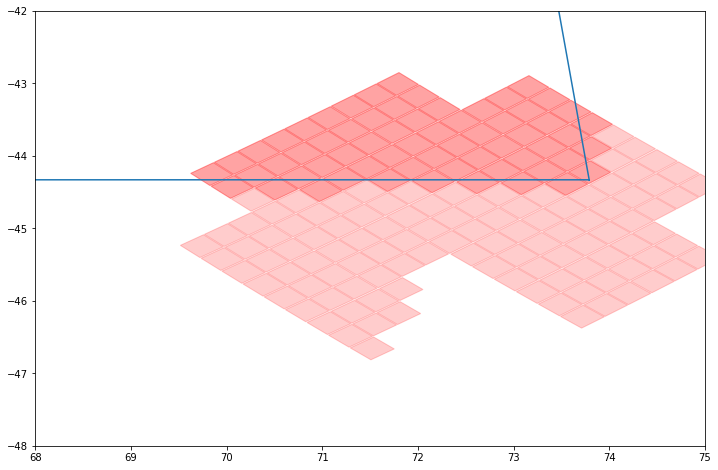

In [25]:
ax = plot_survey_region()
ax = plot_sensors(sensors, ax=ax)
ax = plot_sensors(bundle_list[0][1], ax=ax)